In [16]:
from pytorch_forecasting.models import TemporalFusionTransformer


In [17]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=SMAPE(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [18]:
print(type(tft))


<class 'pytorch_forecasting.models.temporal_fusion_transformer._tft.TemporalFusionTransformer'>


In [20]:
from lightning.pytorch.core.module import LightningModule


In [21]:
print(isinstance(tft, LightningModule))


True


In [37]:
import pandas as pd
import numpy as np
from pytorch_forecasting import TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.models import TemporalFusionTransformer
from lightning.pytorch import Trainer
from lightning.pytorch.core.module import LightningModule
from pytorch_forecasting.metrics import QuantileLoss

df = pd.read_csv("cleaned_asphalt_weather.csv", parse_dates=["timestamp"])
df = df.sort_values("timestamp").set_index("timestamp")
df = df.resample("1h").mean().interpolate()
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["hour_sin"] = np.sin(2 * np.pi * df["hour"] / 24)
df["hour_cos"] = np.cos(2 * np.pi * df["hour"] / 24)
df = df.reset_index()
df["time_idx"] = (df["timestamp"] - df["timestamp"].min()).dt.total_seconds() // 3600
df["time_idx"] = df["time_idx"].astype(int)
df["series_id"] = 0
df["target"] = df["S1_25"]

training = TimeSeriesDataSet(
    df,
    time_idx="time_idx",
    target="target",
    group_ids=["series_id"],
    max_encoder_length=48,
    max_prediction_length=12,
    time_varying_known_reals=["time_idx", "hour", "hour_sin", "hour_cos", "dayofweek"],
    time_varying_unknown_reals=[
        'Humidity', 'Solar_Radiation', 'Rainfall', 'Air_Temp',
        'S1_25', 'S1_50', 'S1_80', 'S1_110',
        'S2_25', 'S2_60', 'S2_100', 'S2_140',
        'S3_25', 'S3_60', 'S3_110', 'S3_170',
        'S4_25', 'S4_60', 'S4_120', 'S4_190'
    ],
    target_normalizer=GroupNormalizer(groups=["series_id"]),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

train_dataloader = training.to_dataloader(train=True, batch_size=64, num_workers=0)
val_dataloader = training.to_dataloader(train=False, batch_size=64, num_workers=0)


tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=0.03,
    hidden_size=16,
    attention_head_size=1,
    dropout=0.1,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)


print("IS LIGHTNING MODULE:", isinstance(tft, LightningModule))

trainer = Trainer(
    max_epochs=30,
    accelerator="auto",
    enable_progress_bar=True,
)

trainer.fit(
    model=tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU avai

IS LIGHTNING MODULE: True


INFO:lightning.pytorch.callbacks.model_summary:
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 0      | train
3  | prescalers                         | ModuleDict                      | 464    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 1.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 18.6 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 3.7 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 1.1 K  | train
8  | static_context_initial_hidden_l

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=30` reached.


In [38]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)

In [47]:
import matplotlib.pyplot as plt
from pytorch_forecasting.metrics import QuantileLoss

raw_output = tft.predict(val_dataloader, mode="raw", return_x=True)

if isinstance(raw_output, tuple):
    raw_predictions, x = raw_output
elif isinstance(raw_output, dict):
    raw_predictions = raw_output["prediction"]
    x = raw_output["x"]
else:
    raise TypeError("Unknown return type from tft.predict")

actual = x["decoder_target"]
pred_tensor = raw_predictions
qloss = QuantileLoss()
loss = qloss(pred_tensor, actual)
print("QuantileLoss:", loss.item())

import numpy as np
from sklearn.metrics import mean_absolute_error

pred_median = pred_tensor[..., 1]
mae = mean_absolute_error(actual.detach().numpy().flatten(), pred_median.detach().numpy().flatten())
print("Median MAE (q=0.5):", mae)

tft.plot_prediction(x, raw_predictions, idx=0, show_future_observed=True)


TypeError: tuple indices must be integers or slices, not tuple

<Axes: title={'center': 'Raw target: S1_25'}>

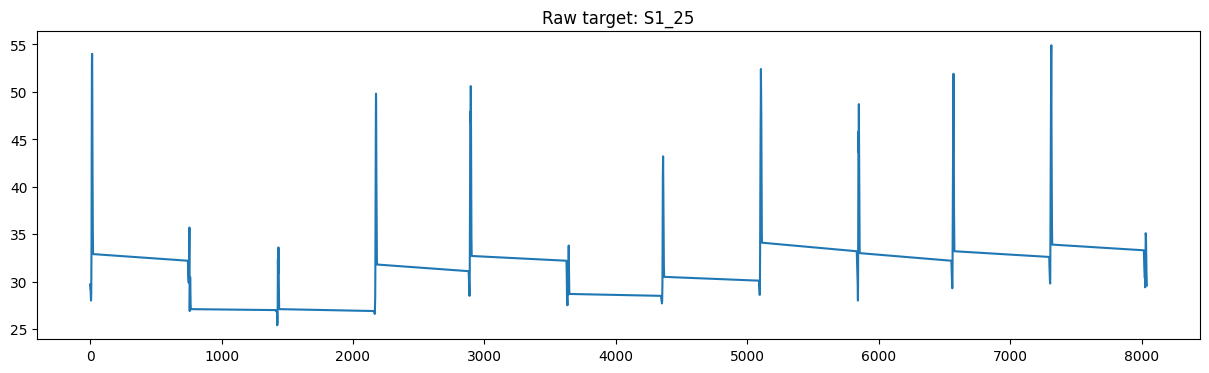

In [36]:
df["S1_25"].plot(figsize=(15, 4), title="Raw target: S1_25")


In [51]:
trainer.callback_metrics

{'train_loss': tensor(0.1590),
 'train_loss_step': tensor(0.1336),
 'val_loss': tensor(0.1494),
 'val_SMAPE': tensor(0.0061),
 'val_MAE': tensor(0.2058),
 'val_RMSE': tensor(0.3981),
 'val_MAPE': tensor(0.0057),
 'train_loss_epoch': tensor(0.1590)}

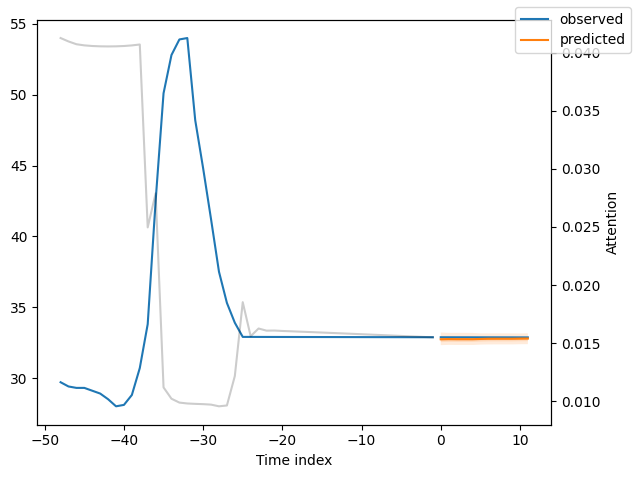

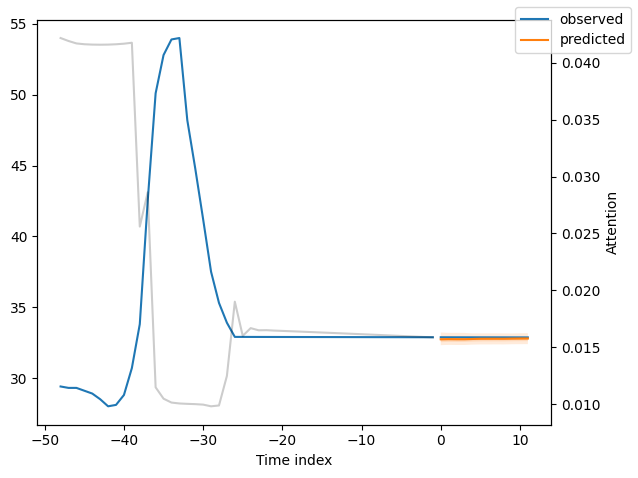

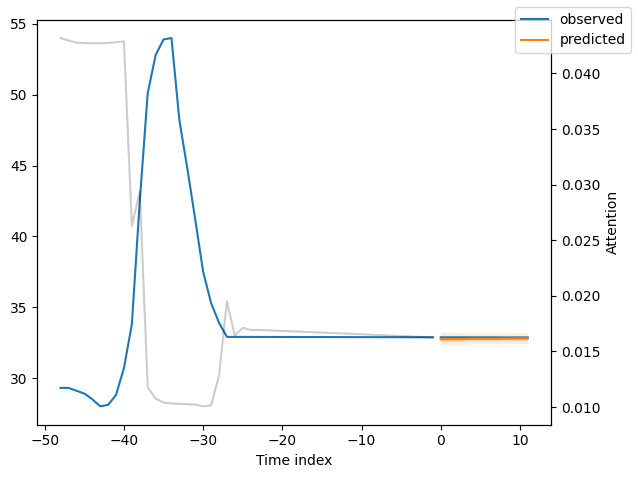

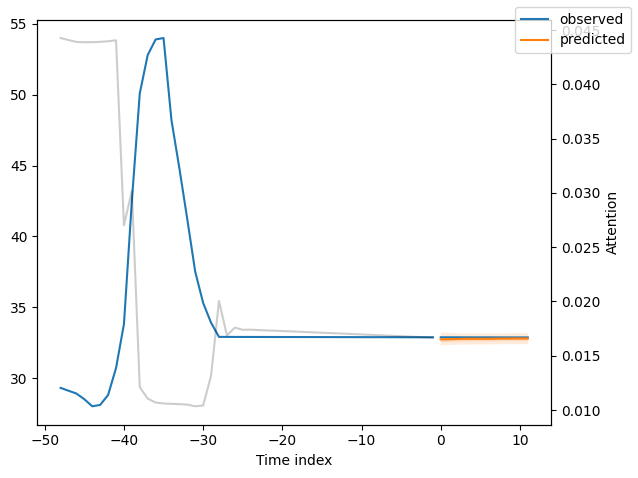

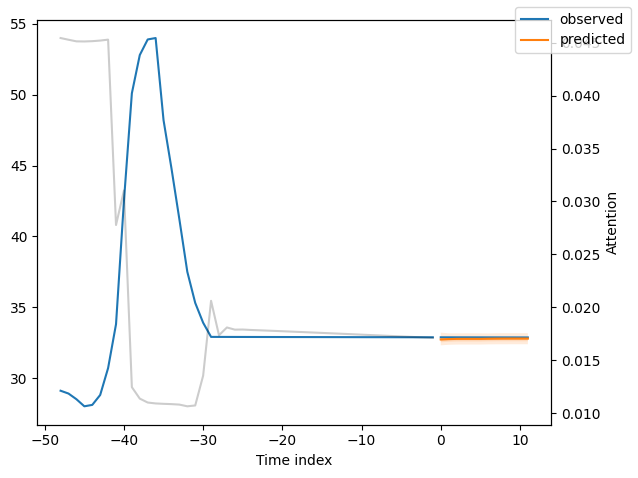

In [52]:
for i in range(5):
    tft.plot_prediction(x, raw_predictions, idx=i, show_future_observed=True)


{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x850 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

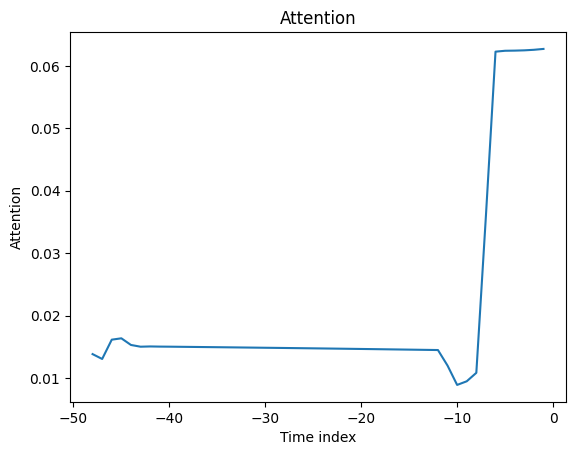

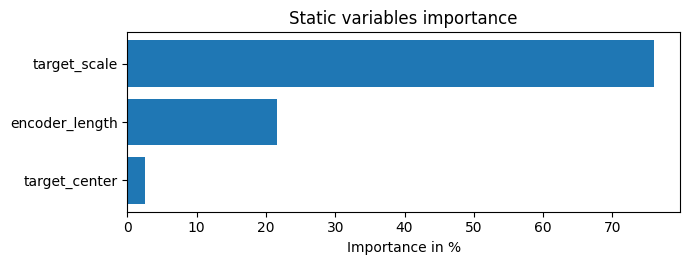

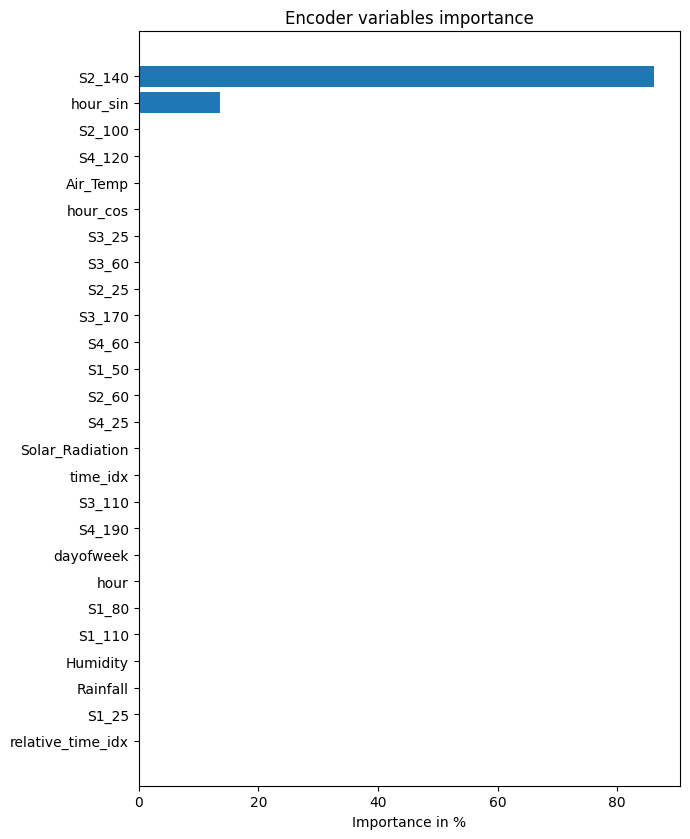

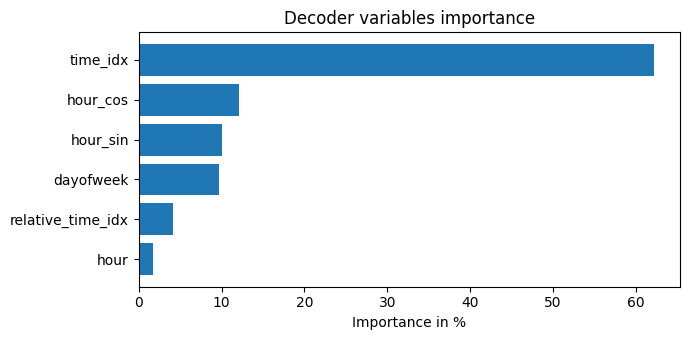

In [62]:
interpreted = tft.interpret_output(raw_preds, reduction="sum")
tft.plot_interpretation(interpreted)


In [63]:
trainer.logger


In [65]:
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters
import torch # Import torch to use torch.save
import joblib

# Save the model's state dictionary
torch.save(tft.state_dict(), "asphalt_tft_model.pth")

# Save the training dataset object
joblib.dump(training, "asphalt_tft_training_dataset.pkl")

print("Model state dictionary saved to asphalt_tft_model.pth")
print("Training dataset object saved to asphalt_tft_training_dataset.pkl")

Model state dictionary saved to asphalt_tft_model.pth
Training dataset object saved to asphalt_tft_training_dataset.pkl
